**This project is an adaptation of the article written by [Pratik Nabriya](https://towardsdatascience.com/feature-engineering-on-time-series-data-transforming-signal-data-of-a-smartphone-accelerometer-for-72cbe34b8a60)**

**In this project, we use mathematical and statistical techniques to transform raw time series data and extract new distinctive features. Then, a machine learning algorithm can be applied to these features to predict human activity.**

The data we are using in this project can be found [here](https://www.cis.fordham.edu/wisdm/dataset.php).

In [69]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
from collections import Counter
import scipy
from scipy.signal import find_peaks
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df = pd.read_csv("WISDM_ar_v1.1_raw.txt", delimiter=',', error_bad_lines=False, names=["user", "activity", "timestamp", "x-axis", "y-axis", "z-axis"])

In [3]:
df

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.69;
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.73;
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.69;
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.73;


In [4]:
Counter(df["user"])

Counter({33: 29453,
         17: 22020,
         20: 56632,
         29: 38245,
         13: 37093,
         15: 28154,
         6: 29704,
         27: 34958,
         36: 32261,
         18: 32811,
         32: 35506,
         35: 22394,
         11: 31659,
         16: 20470,
         5: 28509,
         10: 34883,
         28: 21358,
         26: 32578,
         14: 38192,
         24: 25736,
         12: 32641,
         23: 25673,
         4: 11371,
         30: 25335,
         34: 35947,
         8: 41188,
         31: 44282,
         21: 35436,
         3: 35161,
         22: 22310,
         1: 29978,
         9: 12923,
         25: 13468,
         2: 23525,
         7: 30967,
         19: 45383})

In [5]:
df["activity"].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [6]:
df["user"].unique()

array([33, 17, 20, 29, 13, 15,  6, 27, 36, 18, 32, 35, 11, 16,  5, 10, 28,
       26, 14, 24, 12, 23,  4, 30, 34,  8, 31, 21,  3, 22,  1,  9, 25,  2,
        7, 19], dtype=int64)

In [7]:
df_33 = df[df["user"]==33]
df_33

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.50395286;
1,33,Jogging,49106062271000,5.012288,11.264028,0.95342433;
2,33,Jogging,49106112167000,4.903325,10.882658,-0.08172209;
3,33,Jogging,49106222305000,-0.612916,18.496431,3.0237172;
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164;
...,...,...,...,...,...,...
467623,33,Sitting,774582347000,5.860000,2.180000,7.74;
467624,33,Sitting,774632335000,6.020000,2.410000,7.89;
467625,33,Sitting,774682292000,5.860000,2.410000,7.78;
467626,33,Sitting,774732310000,5.710000,2.300000,7.78;


In [8]:
df_33["activity"].unique()

array(['Jogging', 'Walking', 'Upstairs', 'Downstairs', 'Standing',
       'Sitting'], dtype=object)

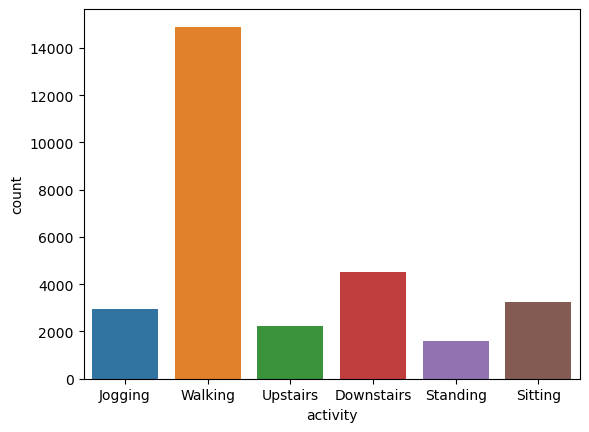

In [9]:
sns.countplot(x='activity', data=df_33)
plt.show()

# Data cleaning and Preprocessing

In [10]:
df.isnull().sum()

user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       1
dtype: int64

In [11]:
df.dropna(inplace=True)

In [12]:
df.isna().sum()

user         0
activity     0
timestamp    0
x-axis       0
y-axis       0
z-axis       0
dtype: int64

In [13]:
df.dtypes

user           int64
activity      object
timestamp      int64
x-axis       float64
y-axis       float64
z-axis        object
dtype: object

In [14]:
df["z-axis"]

0           0.50395286;
1           0.95342433;
2          -0.08172209;
3            3.0237172;
4             7.205164;
               ...     
1098199           1.69;
1098200           1.73;
1098201           1.69;
1098202           1.73;
1098203           1.61;
Name: z-axis, Length: 1098203, dtype: object

In [15]:
df["z-axis"].astype(str).apply(lambda x: x.replace(";", ""))

0           0.50395286
1           0.95342433
2          -0.08172209
3            3.0237172
4             7.205164
              ...     
1098199           1.69
1098200           1.73
1098201           1.69
1098202           1.73
1098203           1.61
Name: z-axis, Length: 1098203, dtype: object

In [16]:
df["z-axis"] = df["z-axis"].astype(str).apply(lambda x: x.replace(";", ""))

In [17]:
df["z-axis"] = df["z-axis"].astype(float)
df["z-axis"]

0          0.503953
1          0.953424
2         -0.081722
3          3.023717
4          7.205164
             ...   
1098199    1.690000
1098200    1.730000
1098201    1.690000
1098202    1.730000
1098203    1.610000
Name: z-axis, Length: 1098203, dtype: float64

In [18]:
df.dtypes

user           int64
activity      object
timestamp      int64
x-axis       float64
y-axis       float64
z-axis       float64
dtype: object

In [19]:
df[df["timestamp"]==0]

,user,activity,timestamp,x-axis,y-axis,z-axis
14398,20,Walking,0,0.0,0.0,0.0
14399,20,Walking,0,0.0,0.0,0.0
14643,20,Walking,0,0.0,0.0,0.0
14644,20,Walking,0,0.0,0.0,0.0
14645,20,Walking,0,0.0,0.0,0.0
...,...,...,...,...,...,...
882377,3,Walking,0,0.0,0.0,0.0
882378,3,Walking,0,0.0,0.0,0.0
938213,22,Downstairs,0,0.0,0.0,0.0
938214,22,Downstairs,0,0.0,0.0,0.0


In [20]:
index_to_drop = df[df["timestamp"]==0].index
index_to_drop

Int64Index([  14398,   14399,   14643,   14644,   14645,   14667,   14689,
              14690,   14710,   14755,
            ...
             433661,  684886,  684887,  780740,  882376,  882377,  882378,
             938213,  938214, 1091328],
           dtype='int64', length=12843)

In [21]:
df_transformed = df.drop(index_to_drop,inplace=False)
df_transformed

,user,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164
...,...,...,...,...,...,...
1098199,19,Sitting,131623331483000,9.000000,-1.570000,1.690000
1098200,19,Sitting,131623371431000,9.040000,-1.460000,1.730000
1098201,19,Sitting,131623411592000,9.080000,-1.380000,1.690000
1098202,19,Sitting,131623491487000,9.000000,-1.460000,1.730000


In [22]:
df_transformed = df_transformed.sort_values(["user", "timestamp"], ascending=True, ignore_index=True)
df_transformed

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1085355,36,Standing,15049012250000,-0.91,9.43,2.533385
1085356,36,Standing,15049062268000,-1.18,9.51,2.492524
1085357,36,Standing,15049112287000,-1.50,9.53,2.533385
1085358,36,Standing,15049162275000,-2.07,8.77,2.179256


# Exploratory Data Analysis

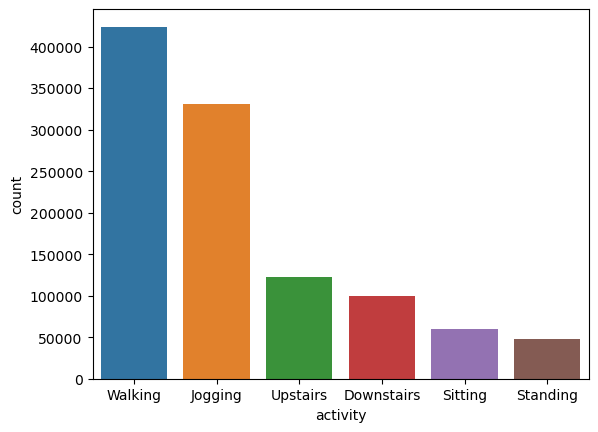

In [23]:
sns.countplot(x="activity", data=df_transformed)
plt.show()

**Walking** and **Jogging** have the majority in the **activity**. **Sitting** and **standing** are less represented.

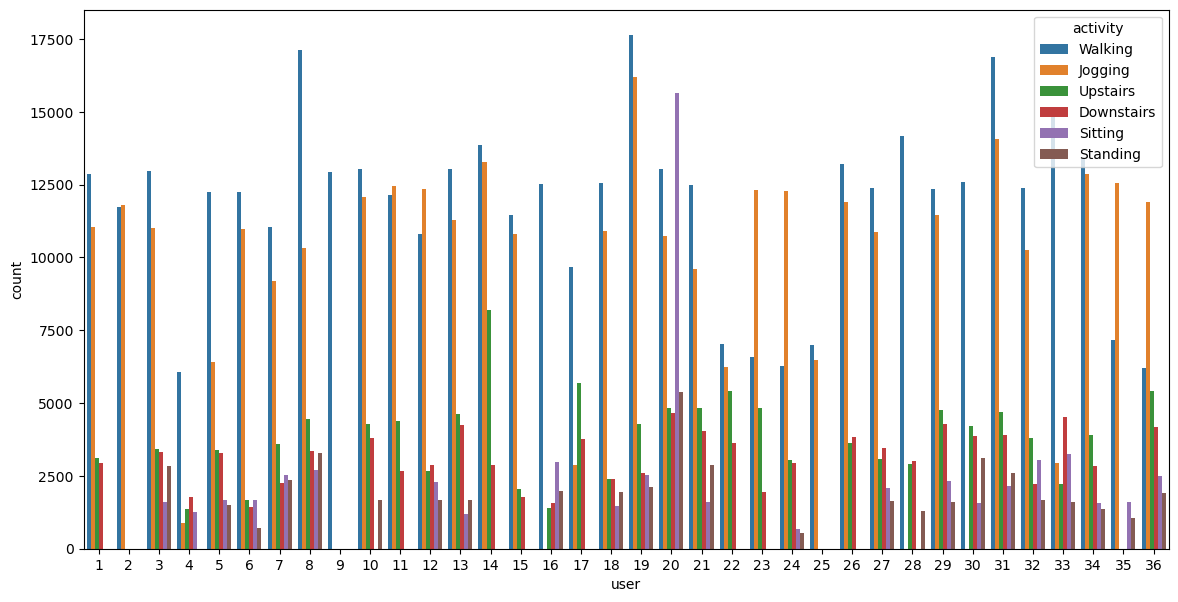

In [24]:
plt.figure(figsize=(14,7))
sns.countplot(x="user", hue="activity", data=df_transformed)
plt.show()

In [25]:
df_transformed["activity"].unique()

array(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [26]:
df_33.columns

Index(['user', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis'], dtype='object')

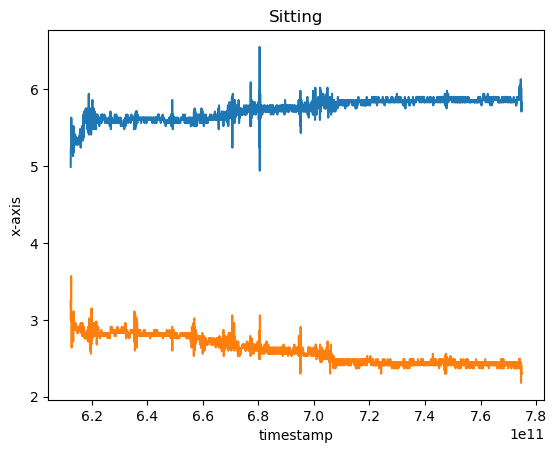

In [27]:
#df_33[df_33["activity"] == "Walking"][["timestamp", "x-axis"]][:400].plot()
sns.lineplot(x="timestamp", y="x-axis", data=df_33[df_33["activity"] == "Sitting"])
sns.lineplot(x="timestamp", y="y-axis", data=df_33[df_33["activity"] == "Sitting"])
plt.title("Sitting")
plt.show()

In [28]:
def plotXYZ_ID(id):
    df_id = df_transformed[df_transformed["user"] == id]
    for activity in df_id["activity"].unique():
        df_activity = df_id[df_id["activity"] == activity]
        
        plt.figure()
        sns.lineplot(x="timestamp", y="x-axis", data=df_activity[:400])
        sns.lineplot(x="timestamp", y="y-axis", data=df_activity[:400])
        sns.lineplot(x="timestamp", y="z-axis", data=df_activity[:400])
        plt.ylabel(activity)
        plt.title(activity, fontsize=17)
        plt.show()

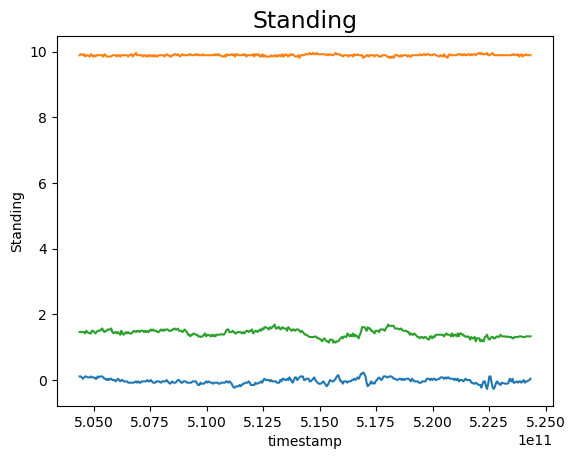

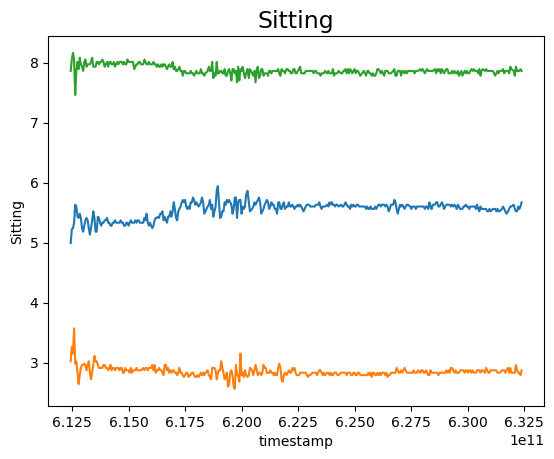

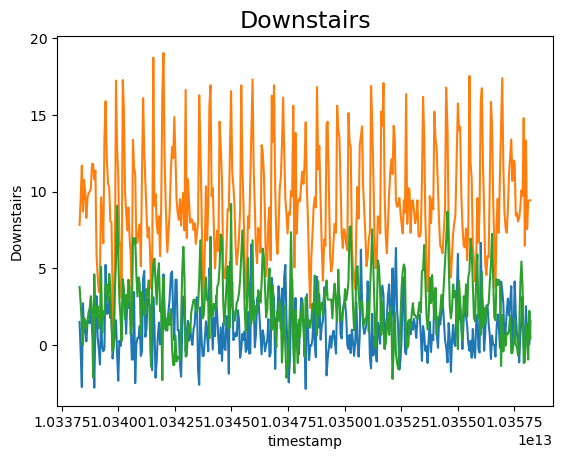

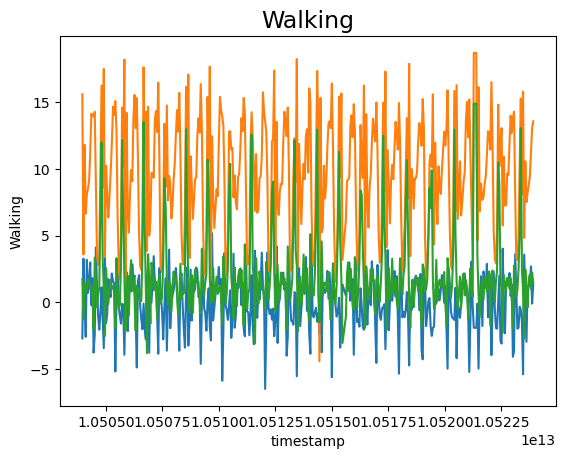

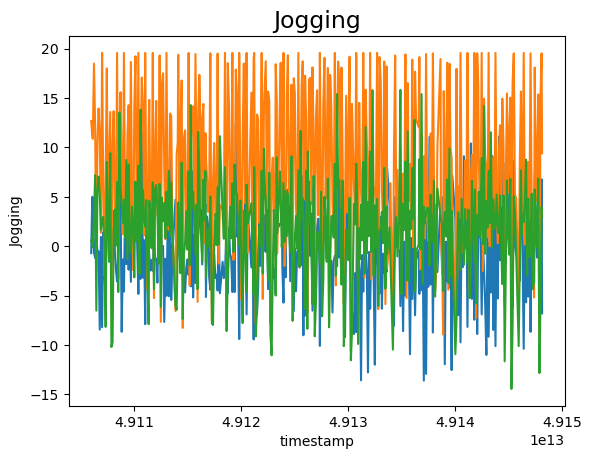

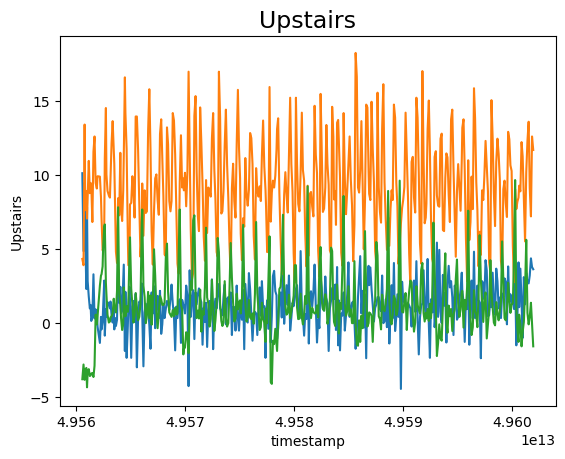

In [29]:
plotXYZ_ID(33)

We can observe a periodic activities for 'Walking', 'Jogging', 'Upstairs', 'Downstairs' while a stationary movements are observed for 'Sitting' and 'Standing'.

Now let's observe the distribution of each activity along the different axes.

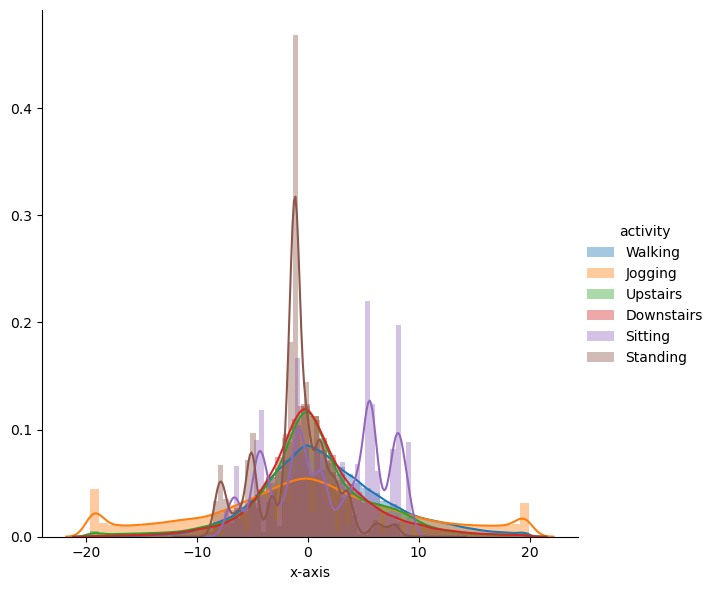

In [30]:
sns.FacetGrid(df_transformed, hue="activity", size=6).map(sns.distplot, "x-axis").add_legend()
plt.show()

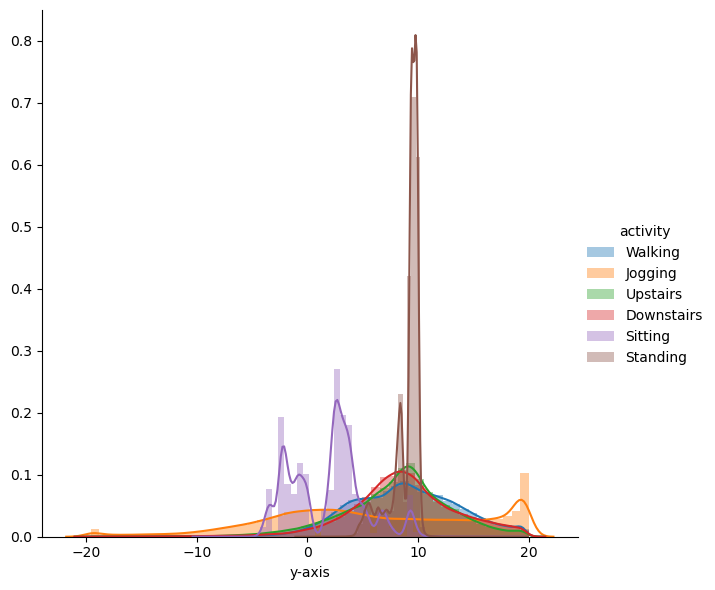

In [31]:
sns.FacetGrid(df_transformed, hue="activity", size=6).map(sns.distplot, "y-axis").add_legend()
plt.show()

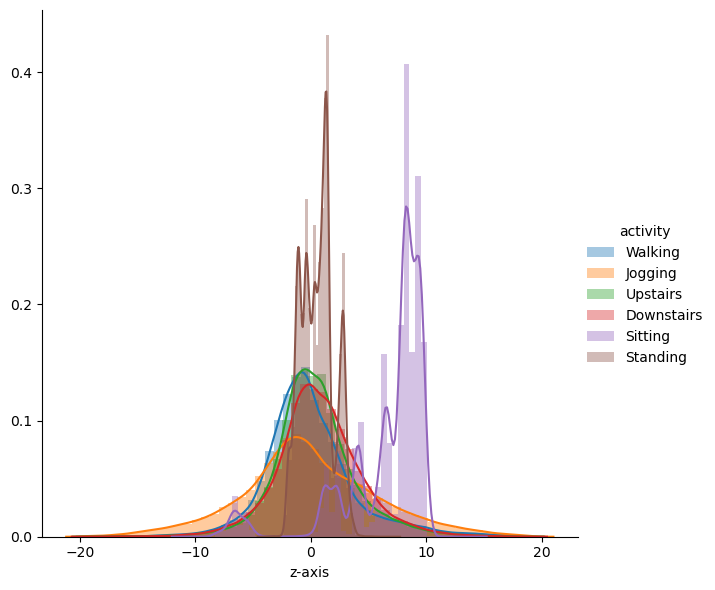

In [32]:
sns.FacetGrid(df_transformed, hue="activity", size=6).map(sns.distplot, "z-axis").add_legend()
plt.show()

The distribution of activities along axes show clearly a difference in scale, eventough some similarities can be remarked.

# Data Transformation

In [33]:
df_transformed

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
1085355,36,Standing,15049012250000,-0.91,9.43,2.533385
1085356,36,Standing,15049062268000,-1.18,9.51,2.492524
1085357,36,Standing,15049112287000,-1.50,9.53,2.533385
1085358,36,Standing,15049162275000,-2.07,8.77,2.179256


let's now slit the data into train and test data

In [34]:
train_df = df_transformed[df_transformed["user"] <= 27] ## First 27 users
train_df 

,user,activity,timestamp,x-axis,y-axis,z-axis
0,1,Walking,4991922345000,0.69,10.80,-2.030000
1,1,Walking,4991972333000,6.85,7.44,-0.500000
2,1,Walking,4992022351000,0.93,5.63,-0.500000
3,1,Walking,4992072339000,-2.11,5.01,-0.690000
4,1,Walking,4992122358000,-4.59,4.29,-1.950000
...,...,...,...,...,...,...
804353,27,Standing,12617112836000,0.99,9.85,-0.694638
804354,27,Standing,12617162793000,0.61,10.00,-0.885323
804355,27,Standing,12617212842000,0.42,10.08,-0.994285
804356,27,Standing,12617262799000,0.38,10.23,-1.035146


In [35]:
test_df = df_transformed[df_transformed["user"] > 27] ## the last 9 users
test_df

,user,activity,timestamp,x-axis,y-axis,z-axis
804358,28,Walking,1506362316000,-0.08,7.40,3.173541
804359,28,Walking,1506412243000,-0.04,8.62,2.873893
804360,28,Walking,1506462292000,0.69,9.53,4.181447
804361,28,Walking,1506512249000,-0.76,8.92,4.140586
804362,28,Walking,1506562328000,-1.57,8.58,3.636633
...,...,...,...,...,...,...
1085355,36,Standing,15049012250000,-0.91,9.43,2.533385
1085356,36,Standing,15049062268000,-1.18,9.51,2.492524
1085357,36,Standing,15049112287000,-1.50,9.53,2.533385
1085358,36,Standing,15049162275000,-2.07,8.77,2.179256


In [36]:
train_df.shape

(804358, 6)

In [37]:
test_df.shape

(281002, 6)

In [38]:
train_df.shape[0]/50

16087.16

In [54]:
from scipy.signal import find_peaks

In [40]:
mode = scipy.stats.mode(train_df["activity"][:500])

In [42]:
mode[0][0]

'Walking'

In [55]:
find_peaks(train_df["x-axis"][:500])

(array([  1,   6,  12,  18,  23,  27,  33,  38,  48,  54,  60,  64,  69,
         74,  80,  85,  89,  96, 101, 105, 110, 116, 122, 127, 131, 139,
        144, 149, 152, 159, 164, 169, 173, 179, 184, 189, 193, 200, 205,
        210, 214, 220, 226, 231, 235, 242, 247, 252, 256, 262, 267, 272,
        275, 278, 282, 288, 293, 296, 308, 312, 316, 323, 327, 332, 336,
        343, 347, 353, 356, 363, 367, 372, 376, 383, 387, 392, 396, 403,
        407, 412, 416, 418, 422, 427, 432, 436, 438, 443, 447, 452, 456,
        463, 467, 472, 476, 483, 488, 492, 496], dtype=int64),
 {})

In [44]:
scipy.stats.skew(train_df["x-axis"][:500])

0.5521445534253339

In [63]:
def transform_data(raw_data):
    
    x_list = list()
    y_list = list()
    z_list = list()
    train_labels = list()
    
    window_size = 100
    step_size = 50

    # creating overlaping windows of size window-size 100
    for i in range(0, raw_data.shape[0] - window_size, step_size):
        xs = raw_data['x-axis'].values[i: i + 100]
        ys = raw_data['y-axis'].values[i: i + 100]
        zs = raw_data['z-axis'].values[i: i + 100]
        label = scipy.stats.mode(raw_data['activity'][i: i + 100])[0][0]

        x_list.append(xs)
        y_list.append(ys)
        z_list.append(zs)
        train_labels.append(label)

    # Statistical Features on raw x, y and z in time domain
    X_train = pd.DataFrame()

    # mean
    X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
    X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
    X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

    # std dev
    X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
    X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
    X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

    # avg absolute diff
    X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # min
    X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
    X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
    X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

    # max
    X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
    X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
    X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

    # max-min diff
    X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
    X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
    X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

    # median
    X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
    X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
    X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

    # median abs dev 
    X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # interquartile range
    X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # negtive count
    X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
    X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
    X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

    # positive count
    X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
    X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
    X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

    # values above mean
    X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
    X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
    X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

    # number of peaks
    X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
    X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
    X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

    # skewness
    X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: scipy.stats.skew(x))
    X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: scipy.stats.skew(x))
    X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: scipy.stats.skew(x))

    # kurtosis
    X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: scipy.stats.kurtosis(x))
    X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: scipy.stats.kurtosis(x))
    X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: scipy.stats.kurtosis(x))

    # energy
    X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/100)
    X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/100)
    X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/100))

    # avg resultant
    X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

    # signal magnitude area
    X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/100)) \
                      + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/100)) \
                      + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/100))

    
    # converting the signals from time domain to frequency domain using FFT
    x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])
    z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:51])

    # Statistical Features on raw x, y and z in frequency domain
    # FFT mean
    X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
    X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
    X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

    # FFT std dev
    X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
    X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
    X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

    # FFT avg absolute diff
    X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
    X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

    # FFT min
    X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
    X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
    X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

    # FFT max
    X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
    X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
    X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

    # FFT max-min diff
    X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
    X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
    X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

    # FFT median
    X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
    X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
    X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

    # FFT median abs dev 
    X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
    X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

    # FFT Interquartile range
    X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
    X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

    # FFT values above mean
    X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
    X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
    X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

    # FFT number of peaks
    X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
    X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

    # FFT skewness
    X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: scipy.stats.skew(x))
    X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: scipy.stats.skew(x))
    X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: scipy.stats.skew(x))

    # FFT kurtosis
    X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: scipy.stats.kurtosis(x))
    X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: scipy.stats.kurtosis(x))
    X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: scipy.stats.kurtosis(x))

    # FFT energy
    X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/50)
    X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/50)
    X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/50))

    # FFT avg resultant
    X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

    # FFT Signal magnitude area
    X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/50)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/50)) \
                         + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/50))
    
    
    # Max Indices and Min indices 

    # index of max value in time domain
    X_train['x_argmax'] = pd.Series(x_list).apply(lambda x: np.argmax(x))
    X_train['y_argmax'] = pd.Series(y_list).apply(lambda x: np.argmax(x))
    X_train['z_argmax'] = pd.Series(z_list).apply(lambda x: np.argmax(x))

    # index of min value in time domain
    X_train['x_argmin'] = pd.Series(x_list).apply(lambda x: np.argmin(x))
    X_train['y_argmin'] = pd.Series(y_list).apply(lambda x: np.argmin(x))
    X_train['z_argmin'] = pd.Series(z_list).apply(lambda x: np.argmin(x))

    # absolute difference between above indices
    X_train['x_arg_diff'] = abs(X_train['x_argmax'] - X_train['x_argmin'])
    X_train['y_arg_diff'] = abs(X_train['y_argmax'] - X_train['y_argmin'])
    X_train['z_arg_diff'] = abs(X_train['z_argmax'] - X_train['z_argmin'])

    # index of max value in frequency domain
    X_train['x_argmax_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    X_train['y_argmax_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))
    X_train['z_argmax_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmax(np.abs(np.fft.fft(x))[1:51]))

    # index of min value in frequency domain
    X_train['x_argmin_fft'] = pd.Series(x_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    X_train['y_argmin_fft'] = pd.Series(y_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))
    X_train['z_argmin_fft'] = pd.Series(z_list_fft).apply(lambda x: np.argmin(np.abs(np.fft.fft(x))[1:51]))

    # absolute difference between above indices
    X_train['x_arg_diff_fft'] = abs(X_train['x_argmax_fft'] - X_train['x_argmin_fft'])
    X_train['y_arg_diff_fft'] = abs(X_train['y_argmax_fft'] - X_train['y_argmin_fft'])
    X_train['z_arg_diff_fft'] = abs(X_train['z_argmax_fft'] - X_train['z_argmin_fft'])
    
    
    return X_train, train_labels

In [68]:
X_train, y_train = transform_data(train_df)

In [66]:
X_train.shape

(16086, 112)

In [67]:
len(y_train)

16086

In [65]:
X_train.head()

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,z_arg_diff,x_argmax_fft,y_argmax_fft,z_argmax_fft,x_argmin_fft,y_argmin_fft,z_argmin_fft,x_arg_diff_fft,y_arg_diff_fft,z_arg_diff_fft
0,3.6538,9.8101,-0.4788,5.508084,3.914714,3.201477,4.200456,3.173296,2.261984,-7.35,...,24,9,0,9,37,13,13,28,13,4
1,3.8267,10.0261,-0.6779,5.543900,4.265195,3.200549,4.245502,3.438856,2.196162,-9.58,...,38,9,0,0,5,12,25,4,12,25
2,3.8955,10.0714,-0.6730,5.942122,4.408135,3.365199,4.611740,3.497088,2.345800,-9.58,...,58,0,0,3,4,13,27,4,13,24
3,4.0975,10.0045,-0.4714,5.787474,4.372943,3.437675,4.400350,3.444650,2.444004,-8.24,...,46,0,47,9,33,23,17,33,24,8
4,3.8653,9.9209,-0.5538,5.843144,4.713848,3.454630,4.424276,3.842882,2.513868,-8.96,...,57,0,1,9,33,15,7,33,14,2


In [ ]:
y_train=np.array(y_train)

# Application of a Machine Learning Algorithm: prediction of human activities

In [70]:
scaler = StandardScaler()

In [71]:
scaler.fit(X_train)

StandardScaler()

In [72]:
X_train_scaled = scaler.transform(X_train)

In [73]:
X_train_scaled

array([[ 0.69237844,  0.69831777, -0.4303329 , ...,  0.80766958,
        -0.61542265, -1.2679104 ],
       [ 0.72975255,  0.7547753 , -0.5247273 , ..., -1.40407781,
        -0.70870769,  0.63414101],
       [ 0.74462438,  0.7666157 , -0.52240419, ..., -1.40407781,
        -0.61542265,  0.54356713],
       ...,
       [ 0.03497015,  0.72667722, -0.7712667 , ...,  0.43904501,
         0.1308577 , -0.09045   ],
       [ 0.03613742,  0.72842845, -0.77210617, ...,  2.28216784,
         1.06370815,  1.26815815],
       [ 0.03267886,  0.72644198, -0.78431081, ...,  2.00569941,
        -0.80199274, -1.17733652]])

In [78]:
y_train_df = pd.Series(y_train)

In [79]:
y_train_df.unique()

array(['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting',
       'Standing'], dtype=object)

In [80]:
dict_activities = {'Walking':0, 'Jogging':1, 'Upstairs':2, 'Downstairs':3, 'Sitting':4, 'Standing':5}

In [82]:
y_train_transformed = y_train_df.map(dict_activities)
y_train_transformed

0        0
1        0
2        0
3        0
4        0
        ..
16081    5
16082    5
16083    5
16084    5
16085    5
Length: 16086, dtype: int64

In [83]:
X_test, y_test = transform_data(test_df)

In [84]:
y_test_df = pd.Series(np.array(y_test))

In [85]:
y_test_transformed = y_test_df.map(dict_activities)
y_test_transformed

0       0
1       0
2       0
3       0
4       0
       ..
5614    5
5615    5
5616    5
5617    5
5618    5
Length: 5619, dtype: int64

In [86]:
X_test_scaled = scaler.transform(X_test)

**Modelling**

In [74]:
lr_clf = LogisticRegression(random_state=42)

In [87]:
lr_clf.fit(X_train_scaled, y_train_transformed)

LogisticRegression(random_state=42)

**Application of the model on the test data**

In [88]:
y_pred_lr = lr_clf.predict(X_test_scaled)

In [89]:
## Accuracy
acc_lr = accuracy_score(y_test_transformed, y_pred_lr)
acc_lr

0.8433885032924008

In [94]:
cm_lr = confusion_matrix(y_test_transformed, y_pred_lr)
cm_lr

array([[1838,  274,   28,   49,    8,    0],
       [  39, 1437,   29,   17,    0,    0],
       [  42,   43,  406,  131,    7,   11],
       [  31,    5,  108,  432,    0,    0],
       [   0,    0,    1,    0,  359,    1],
       [   1,    0,    7,    1,   47,  267]], dtype=int64)

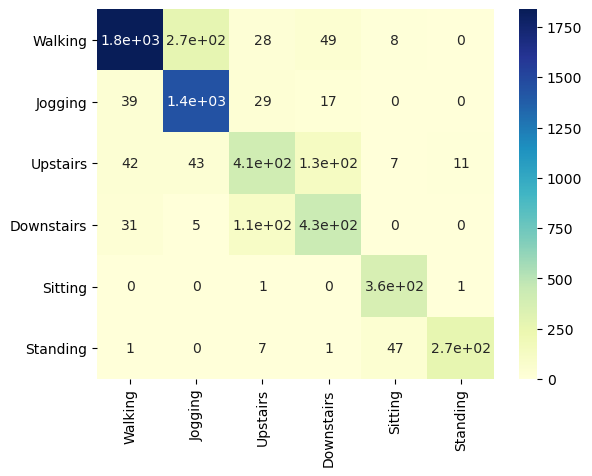

In [97]:
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
sns.heatmap(cm_lr, xticklabels=labels, yticklabels=labels, annot=True, cmap='YlGnBu')
plt.show()

In [99]:
report_lr = classification_report(y_test_transformed, y_pred_lr)
print(report_lr)

              precision    recall  f1-score   support

           0       0.94      0.84      0.89      2197
           1       0.82      0.94      0.88      1522
           2       0.70      0.63      0.67       640
           3       0.69      0.75      0.72       576
           4       0.85      0.99      0.92       361
           5       0.96      0.83      0.89       323

    accuracy                           0.84      5619
   macro avg       0.83      0.83      0.82      5619
weighted avg       0.85      0.84      0.84      5619



Let's apply `RandomForest()` algorithm

In [90]:
from sklearn.ensemble import RandomForestClassifier

In [91]:
rf_clf = RandomForestClassifier()

In [92]:
rf_clf.fit(X_train_scaled, y_train_transformed)

RandomForestClassifier()

In [93]:
y_pred_rf = rf_clf.predict(X_test_scaled)

In [100]:
## Accuracy
acc_rf = accuracy_score(y_test_transformed, y_pred_rf)
acc_rf

0.8336002847481758

In [101]:
cm_rf = confusion_matrix(y_test_transformed, y_pred_rf)
cm_rf

array([[1797,  250,  114,   36,    0,    0],
       [  42, 1424,   46,   10,    0,    0],
       [  60,   44,  469,   61,    2,    4],
       [  71,   10,  118,  377,    0,    0],
       [   0,    0,    0,    0,  354,    7],
       [   0,    0,    2,    2,   56,  263]], dtype=int64)

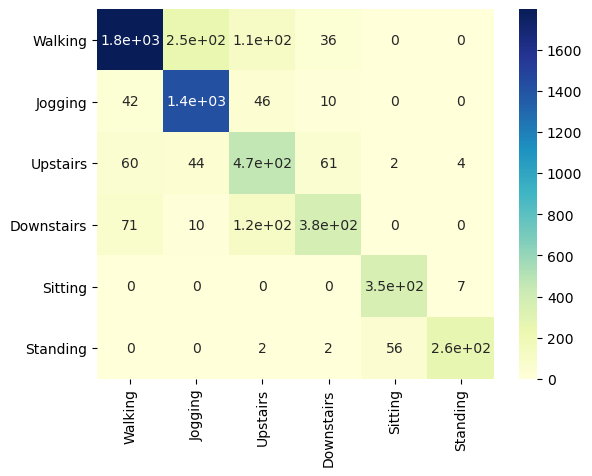

In [102]:
labels = ['Walking', 'Jogging', 'Upstairs', 'Downstairs', 'Sitting', 'Standing']
sns.heatmap(cm_rf, xticklabels=labels, yticklabels=labels, annot=True, cmap='YlGnBu')
plt.show()

In [103]:
report_rf = classification_report(y_test_transformed, y_pred_rf)
print(report_rf)

              precision    recall  f1-score   support

           0       0.91      0.82      0.86      2197
           1       0.82      0.94      0.88      1522
           2       0.63      0.73      0.68       640
           3       0.78      0.65      0.71       576
           4       0.86      0.98      0.92       361
           5       0.96      0.81      0.88       323

    accuracy                           0.83      5619
   macro avg       0.83      0.82      0.82      5619
weighted avg       0.84      0.83      0.83      5619



# Conclusion

In this project, we took only **3 features (tri-axial accelerometer signal in the x, y and z axes)** from the raw data which were transformed to form a set of 112 new features. To begin, we had to transform the raw data using the **"windowing "** technique. In addition, some **statistical and mathematical transformations** were applied to the transformed data to create the **new 112 distinguishing features**. Then, some machine learning algorithms were applied. Logistic regression was the most successful algorithm on the data.